# Training a multi-task regression model for neural crest cells

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [2]:
experiment = 'multi_task_DilatedConvModel'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 500 # Length of the input sequence
training = False

## Load Data

In [3]:
data= pd.read_csv("../data/normalized_peaks.csv")
data.index.name = 'position #'
ad = data.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
cell_types = pd.DataFrame({'cell type': data.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [4]:
data

anterior/posterior axis  central nervous system  forebrain  \
position #                                                               
0                          4.658859                4.533672   3.744909   
1                          4.759777                4.715077   3.915141   
2                          4.851202                4.694130   3.741332   
3                          4.918804                4.971179   4.511633   
4                          5.091230                5.155695   4.589974   
...                             ...                     ...        ...   
370053                     2.385099                1.837305   1.710130   
370054                     3.310180                3.806458   2.857530   
370055                     2.983381                2.334474   2.777409   
370056                     3.136339                1.905814   0.985993   
370057                     3.098970                1.606249   3.000864   

            immature eye  integument  lateral plate mesoderm  mesenchyme cell  \
position #                                                                      
0               4.677198    3.910345                4.776952         4.074234   
1               4.802952    3.762256                4.759200         4.074087   
2               4.328792    3.891091                4.966067         4.201415   
3               4.538608    4.418892                4.899892         4.531088   
4               4.901204    4.731492                5.050992         4.468658   
...                  ...         ...                     ...              ...   
370053          1.723122    2.184391                2.326503         1.820542   
370054          3.068696    3.365575                4.251009         3.218051   
370055          2.813908    2.786776                2.216906         3.053263   
370056          1.995366    2.621371                2.621371         3.126667   
370057          2.813908    2.083915                2.216906         2.576328   

            musculature system  neural crest  neural keel  neural stem cell  \
position #                                                                    
0                     4.654862      4.511633     4.800124          3.995971   
1                     4.553247      4.739486     4.790696          4.128371   
2                     4.509935      4.834991     4.681877          3.961688   
3                     4.722845      4.691382     4.823491          4.373438   
4                     5.062934      5.074762     4.985431          4.415342   
...                        ...           ...          ...               ...   
370053                1.922973      1.471810     2.651219          2.077131   
370054                3.538135      3.645372     3.987058          3.310180   
370055                2.759981      3.251418     3.467993          2.507627   
370056                2.756784      2.290252     2.825516          2.608640   
370057                2.710588      2.284540     3.068696          2.326503   

            periderm/epidermis  primary neuron  segmental plate       YSL  
position #                                                                 
0                     3.671893        3.417105         4.706086  3.662167  
1                     3.930637        3.762256         4.786094  3.768121  
2                     4.280661        4.920982         4.964999  4.249963  
3                     4.534809        4.642561         5.069323  4.093997  
4                     4.427364        4.779970         5.267927  4.454447  
...                        ...             ...              ...       ...  
370053                2.268933        1.552899         2.468091  2.502551  
370054                3.322940        3.442145         3.689176  2.822574  
370055                1.933072        2.805062         2.717196  1.456314  
370056                2.515921        2.649961         1.977763  2.763079  
370057                1.933072        2.463570         

In [5]:
ad.obs

cell type
cell type                                       
anterior/posterior axis  anterior/posterior axis
central nervous system    central nervous system
forebrain                              forebrain
immature eye                        immature eye
integument                            integument
lateral plate mesoderm    lateral plate mesoderm
mesenchyme cell                  mesenchyme cell
musculature system            musculature system
neural crest                        neural crest
neural keel                          neural keel
neural stem cell                neural stem cell
periderm/epidermis            periderm/epidermis
primary neuron                    primary neuron
segmental plate                  segmental plate
YSL                                          YSL

In [6]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

In [7]:
ad.var.head()

chrom  start    end
0  chr1   5231   5732
1  chr1   5786   6287
2  chr1  10087  10588
3  chr1  10990  11491
4  chr1  11894  12395

In [8]:
ad.X[0:5,0:5]

array([[4.65885913, 4.7597768 , 4.8512016 , 4.91880367, 5.09123001],
       [4.53367234, 4.71507734, 4.69412965, 4.97117863, 5.155695  ],
       [3.74490908, 3.91514078, 3.74133195, 4.51163258, 4.58997422],
       [4.6771982 , 4.80295157, 4.3287915 , 4.53860808, 4.90120411],
       [3.91034461, 3.76225644, 3.89109145, 4.41889173, 4.7314921 ]])

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [9]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 333823 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of `seq_len`to train the model as follows:

In [10]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


chrom  start    end
0  chr1   5232   5732
1  chr1   5787   6287
2  chr1  10088  10588

## Split data

In [11]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [12]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 303354 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 13390 intervals
Final sizes: train: (15, 303354), val: (15, 17079), test: (15, 13390)


## Make labeled sequence datasets

In [13]:
import grelu.data.dataset

In [14]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [15]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [16]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, 
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate




      
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':64,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning


model = grelu.lightning.LightningModel(model_params, train_params)

In [17]:
print(model)

LightningModel(
  (model): DilatedConvModel(
    (embedding): DilatedConvTrunk(
      (conv_tower): ConvTower(
        (blocks): ModuleList(
          (0): Stem(
            (conv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=same)
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
          )
          (1): ConvBlock(
            (norm): Norm(
              (layer): Identity()
            )
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
            (dropout): Dropout(
              (layer): Identity()
            )
            (channel_transform): ChannelTransform(
              (layer): Identity()
            )
          )
          (2): ConvBlock(
            (norm): Norm(
       

## Train model

In [18]:
if training:
    trainer = model.train_on_dataset(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
    )
else:
    trainer = None


## Load best model from checkpoint

In [19]:
try:
    best_checkpoint = trainer.checkpoint_callback.best_model_path
except:
    best_checkpoint = 'multi_task_DilatedConvModel/2025_27_04_19_18/version_0/checkpoints/epoch=7-step=37920.ckpt'
print(best_checkpoint)

multi_task_DilatedConvModel/2025_27_04_19_18/version_0/checkpoints/epoch=7-step=37920.ckpt


In [20]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Evaluate model on the test set

In [21]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 16.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0194681882858276
        test_mse            1.0223318338394165
      test_pearson          0.4383767247200012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Inspect training curves

In [22]:
metrics_path = "multi_task_DilatedConvModel/2025_26_04_15_05/version_0/metrics.csv"

metrics_df = pd.read_csv(metrics_path)

metrics_df.head()

epoch  step  train_loss_epoch  train_loss_step  val_loss   val_mse  \
0      0     0               NaN              NaN   7.56159  7.489322   
1      0    49               NaN         1.032562       NaN       NaN   
2      0    99               NaN         1.095526       NaN       NaN   
3      0   149               NaN         1.007000       NaN       NaN   
4      0   199               NaN         0.933161       NaN       NaN   

   val_pearson  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [23]:
# Checking if the 'epoch' and 'train_loss' columns exits
if 'epoch' in metrics_df.columns and 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss', marker='o')
else:
    print("Columns 'epoch' or 'train_loss' not found in metrics file.")

Columns 'epoch' or 'train_loss' not found in metrics file.


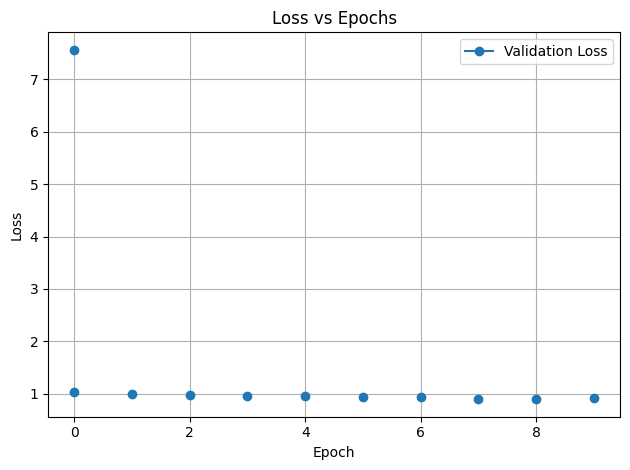

In [24]:
## Plotting validation loss (if logged)
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss', marker='o')

    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

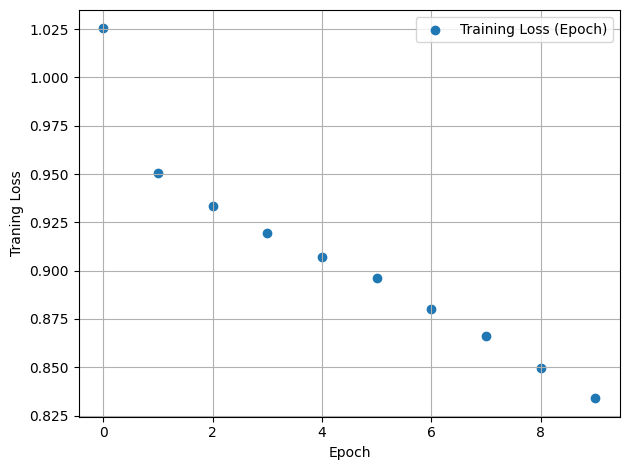

In [25]:
plt.scatter(metrics_df['epoch'], metrics_df['train_loss_epoch'], label='Training Loss (Epoch)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Traning Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

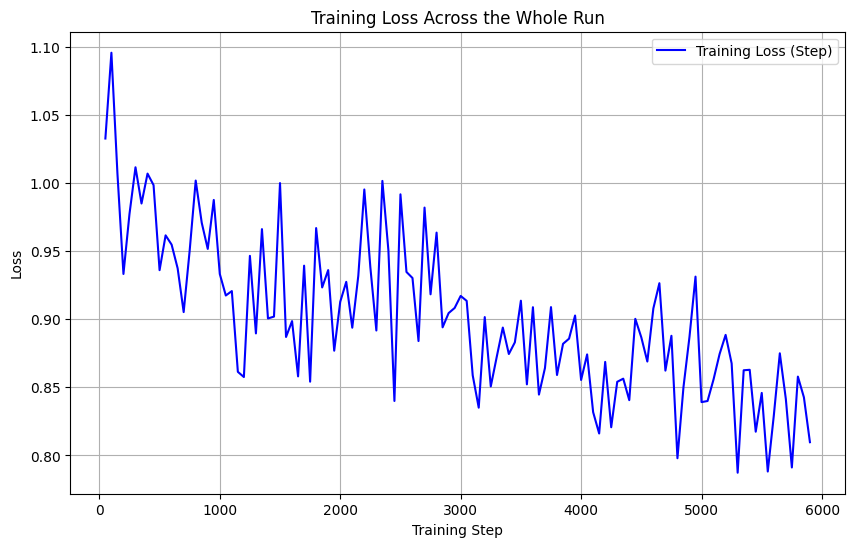

In [26]:
# plot training loss at each step
df_train = metrics_df.dropna(subset=['train_loss_step'])

plt.figure(figsize=(10, 6))
plt.plot(df_train['step'], df_train['train_loss_step'], label='Training Loss (Step)', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Across the Whole Run')
plt.legend()
plt.grid(True)
plt.show()

## Run inference on held out sequences

In [27]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.65it/s]


(13390, 15, 1)

In [28]:
preds_df = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8,
    return_df=True # Return the output as a pandas dataframe
    )
preds_df.head()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.64it/s]


anterior/posterior axis  central nervous system  forebrain  immature eye  \
0                 2.287378                2.185496   2.554604      2.461776   
1                 1.948393                1.849066   1.999329      1.926863   
2                 1.633824                1.441574   1.632096      1.543468   
3                 2.591313                2.351555   2.529876      2.560392   
4                 2.717038                2.855979   2.661363      2.741569   

   integument  lateral plate mesoderm  mesenchyme cell  musculature system  \
0    2.139232                2.218102         2.159050            2.055662   
1    1.961717                1.878543         1.848438            1.941527   
2    1.786043                1.698700         1.610143            1.785499   
3    2.356230                2.586692         2.508635            2.204630   
4    2.524162                2.633785         2.677896            2.551074   

   neural crest  neural keel  neural stem cell  periderm/epidermis  \
0      2.228493     2.264052          2.466351            2.084469   
1      1.940781     1.890582          1.909304            2.056766   
2      1.732721     1.561996          1.472180            1.898378   
3      2.566044     2.690799          2.619775            2.338428   
4      2.695457     2.803629          2.725083            2.443843   

   primary neuron  segmental plate       YSL  
0        2.894904         2.114880  2.410789  
1        2.042186         1.913879  1.955152  
2        1.686928         1.643003  2.363239  
3        2.543217         2.410444  2.503648  
4        2.621725         2.692882  2.411244

## Correlations for each cell type in test set

In [29]:
test_metrics.sort_values(by = 'test_pearson', ascending= False)

test_mse  test_pearson
primary neuron           0.934402      0.490777
central nervous system   1.108382      0.485079
neural stem cell         1.061237      0.477654
neural keel              0.964143      0.477420
forebrain                0.971863      0.470405
mesenchyme cell          1.072113      0.463668
lateral plate mesoderm   0.937913      0.447106
immature eye             1.033189      0.444023
YSL                      0.871131      0.433787
anterior/posterior axis  0.980991      0.427510
segmental plate          1.068215      0.421375
neural crest             1.052803      0.408826
musculature system       1.076104      0.401209
integument               1.115684      0.398551
periderm/epidermis       1.086806      0.328259

In [30]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

## Inpsecting the performance of the trained model

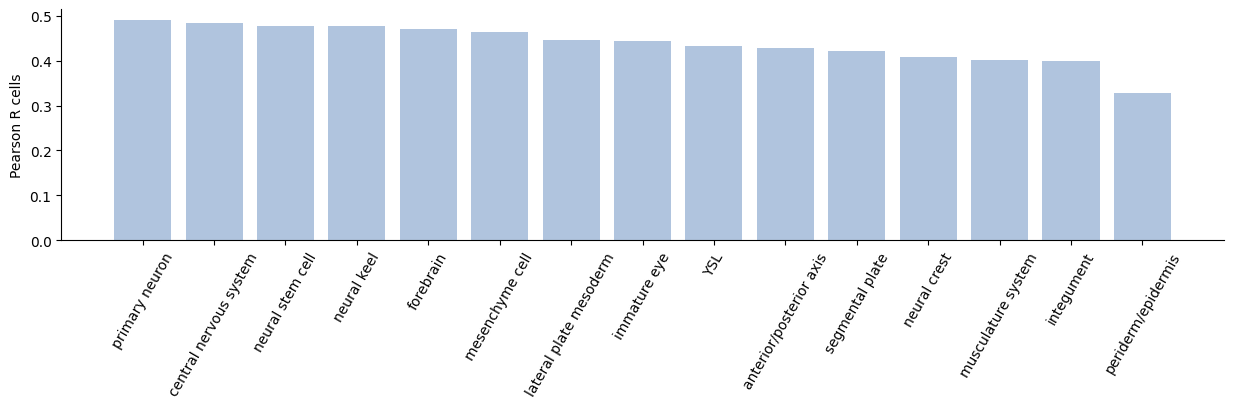

In [31]:
from plotlib import _bar_plot
import matplotlib.pyplot as plt

corrvalues_sorted = test_metrics.sort_values(by = 'test_pearson', ascending= False)

ax = _bar_plot(corrvalues_sorted['test_pearson'], ylabel = 'Pearson R cells', horizontal = False, xticklabels = corrvalues_sorted.index, rotation = 60)
plt.show()

## Interpreting model predictions and attributions for neural crest cells

**Note**: We want to find out what the model thinks that is important in the sequence to get a high signal.
grelu has a few methods that you can easily select (saliency, integratedgradients, and deepliftshap)
However, you won't be able to use deepliftshap if you trained a model with GELU or with attention

### Model performance for neural crest cell

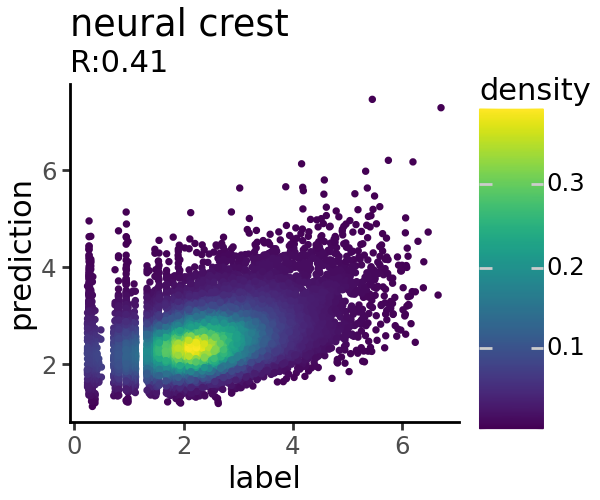

In [32]:
import grelu.visualize
%matplotlib inline
import plotnine as p9
from scipy.stats import pearsonr

fig = grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    tasks= [8],
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)



pcorr = str(round(test_metrics['test_pearson'].values[8], 2))
fig + p9.labs(title = f'{ad.obs_names[8]}',
              subtitle = f'R:{pcorr}') 

### Plot performance of model on all cell types

In [33]:
# create list of predictions
n = preds.shape[1]
preds_list = [preds[:,e,:].reshape(-1) for e in range(n)]
len(preds_list)

15

In [34]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

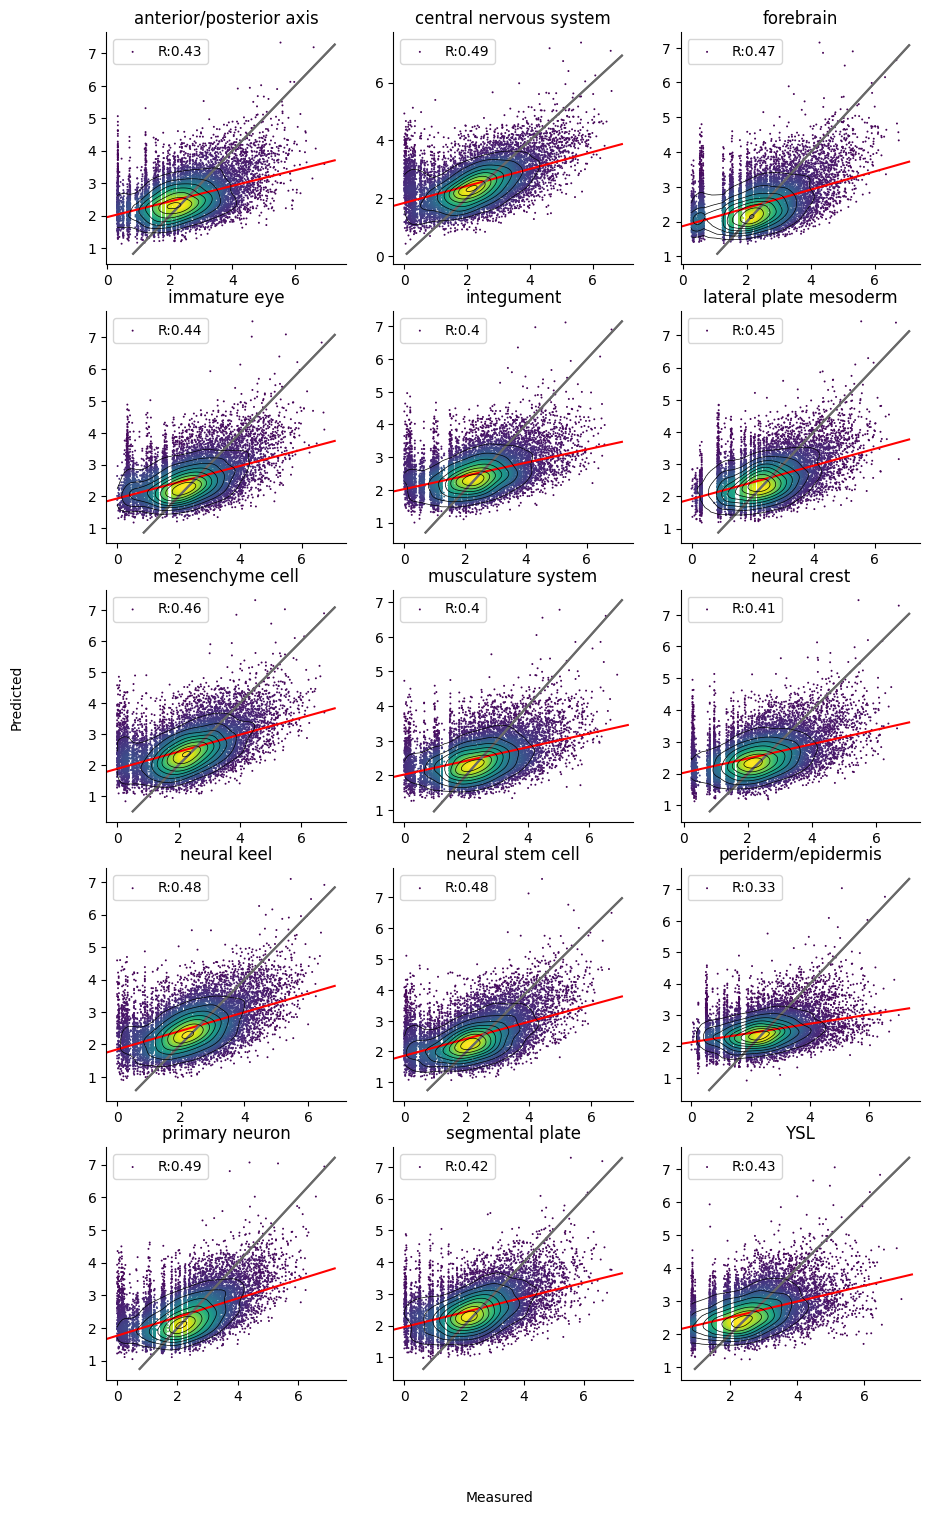

In [35]:
from plotlib import plot_scatter

allfig = plot_scatter(list(ad_test.X.toarray()), preds_list, titles = ad_test.obs_names, xlabel = 'Measured', ylabel = 'Predicted', 
                      sizes = 2, contour = True, color_density = True, color = 'grey', lw = 0., legend = True, 
                      include_fit = True, include_mainvar = False, diagonal = True)
plt.show()

### Selecting trusted well-predicted data points

In [36]:
# determine index for neural crest cell
nc_index = list(ad.obs_names).index('neural crest')
nc_index

8

In [37]:
# select sequence with highest signal and close to measured
nc_test_actual = list(ad_test.X.toarray())[nc_index]
nc_test_pred = preds_list[nc_index]
test_mask = (np.abs(nc_test_actual - nc_test_pred) < 1.) & (nc_test_pred > 6.)
print(f'Selected {int(np.sum(test_mask))} sequences for neural crest cells')

Selected 3 sequences for neural crest cells


In [38]:
# indices of sequences
selected_indices = ad_test.var[test_mask]
selected_indices

chrom     start       end
49455  chr4     20623     21123
61678  chr4  72723283  72723783
62189  chr4  74929056  74929556

In [39]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    selected_indices,
    output_type="strings",
    genome=genome
)


len(input_seqs)

3

In [40]:
input_seqs

['ACCGGGCAGCGGGCACGAGCACTCGCCGGTAATCCCTCGCCGATCAAACGCTTTGATTTCTCCTCAGAATCGACTTTTCACAGTGTAATAAAGCGCGCGCCCCTCCCTGCGGCTGCCACACACACACACTCGCACACTGCCGGACCGCCCGAGCCCCGCTGCCGACGCCCCGCCCCTCACCGCTCCCCTCACTCTGATTGGACAGCGGCCGGGACCTCCGCGACGGTGATTGGAGGAGCAGTCGCTTCACTCAAACGCATCCTCGGATTTCTGGTTCCTGACTGTCGGGACCGGCTGTCAATCAGAGGTTCCCCCTGAGCTTCTCTGCGATTGGCCGAGCCCGCTCCCGCCCTCTGCCTGAGCCAGGTTAGCCCCGCCTCTTCCGCGCTGACATCCGGGCTCTTTCAGCGCGTCACCGTCAGCGCATTGTCTCCGCGTTTGCGTGTAAATCCGTAACCCTGACGAGCAGCGAGAGAGCTGATCAACCGATCACCAGCAGC',
 'CTGAACAGTTAGACCGACTGTGATTTGATTTACTTTAGATTAAAAAAAAAACACATTTTTATTAATAACGTTACCTTGGTCCACGTTTTATCCCGAAATACTTTACAGCGCCTGCGTGAGCCGGCCTGAGCCTCCGCCTAATCTGACAGGAGGGTAGTTGTTGGTTGACCAGTCCTACTATGGCGAGCATTTACCTCGTGAAATATTAATTAGGTAACGTATTAGTCGATTAACTGCCCTCTGATTGGCTGAAAGGCAGCGGTTGGTAGGCGGGCGTTGAGTAGGCGACGAATAAACAAACGACAGTACTGTCTTATGAATATTAATTGAACGACGTGCGTGGAACGCACCTGAGAGACGTCAGGGCGACCTTATTAATATTCATGAGCTAAACCGTCGCAATAGTAGGGACCGTATTTCTCCCAACATCACAATCATGAAGCGGGATGGTGGCAGCCGGTGGCTCTGTCGTGTCTTTGTCTGGCCCGGGTTA

In [41]:
len(input_seqs[0])

500

In [42]:
input_seqs[0][:10]

'ACCGGGCAGC'

### Forward propagation of influence using integrated gradients

In [43]:
from grelu.transforms.prediction_transforms import Aggregate

neural_crest_peaks = Aggregate(
    tasks = ["neural crest"],
    model = model,
)

neural_crest_peaks

Aggregate()

In [44]:
import grelu.interpret.score

attrs = grelu.interpret.score.get_attributions(
    model, input_seqs, prediction_transform=neural_crest_peaks, device=0,
    method="integratedgradients",
)

In [45]:
attrs.shape

(3, 4, 500)

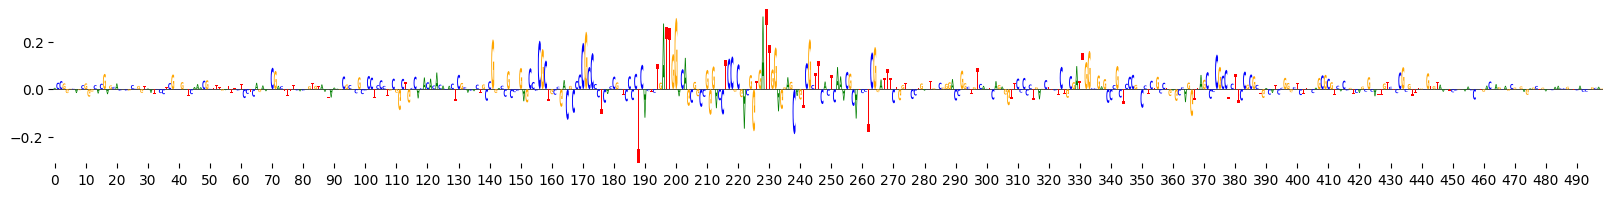

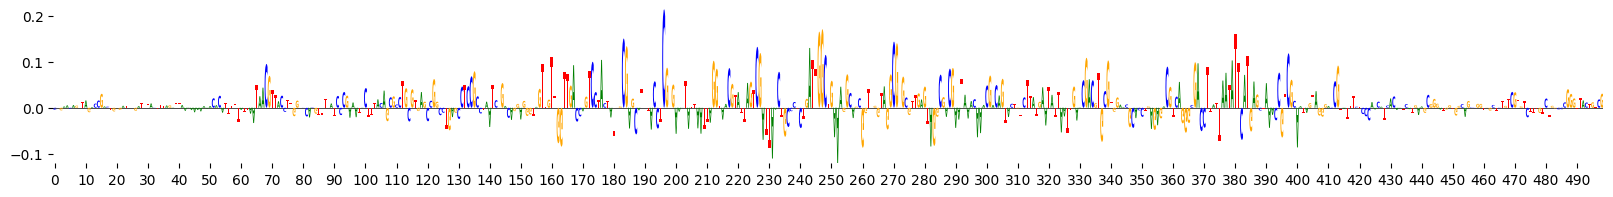

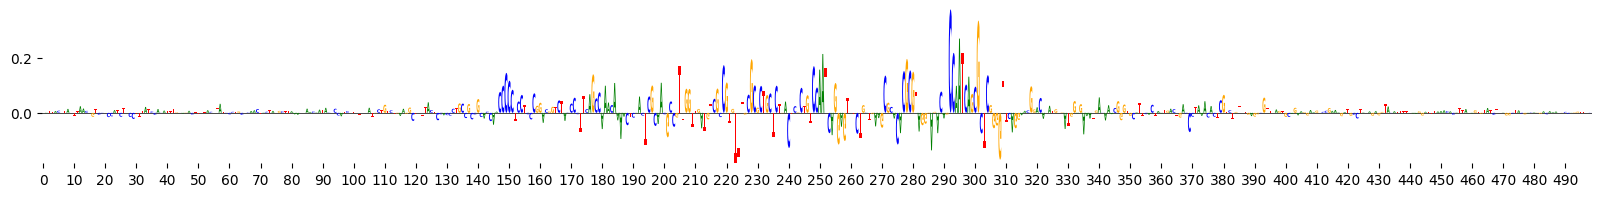

In [46]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

### Using integrated gradients from Captum

In [47]:
from utils import get_captum_integrated_gradients


captum_attrs = get_captum_integrated_gradients(
    model, input_seqs, genome, prediction_transform=neural_crest_peaks, device=0,
    multiply_by_inputs= True,
)

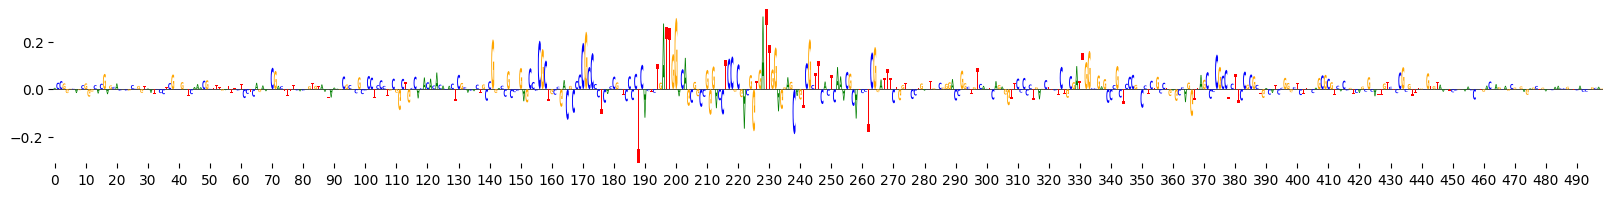

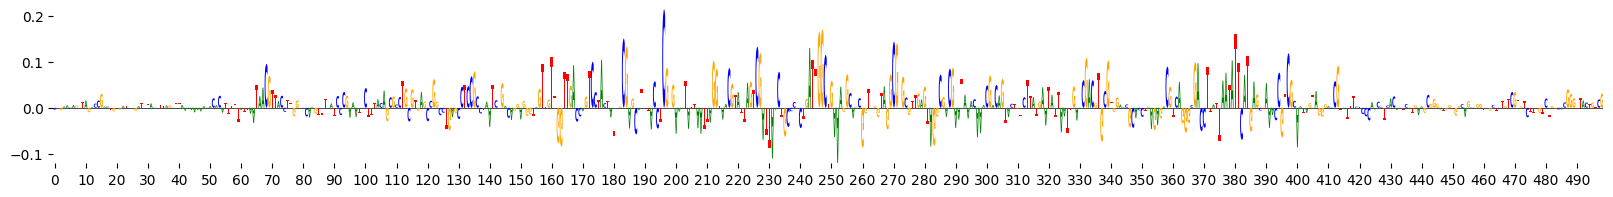

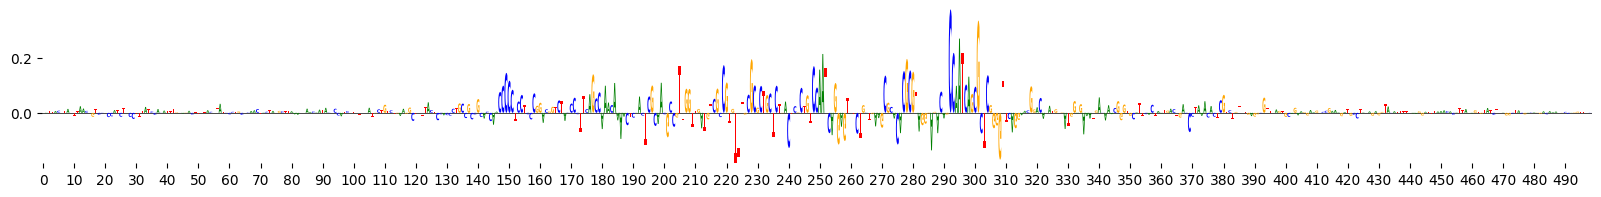

In [48]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        captum_attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

In [49]:
captum_attrs = get_captum_integrated_gradients(
    model, input_seqs, genome, prediction_transform=neural_crest_peaks, device=0,
    multiply_by_inputs= False,
)

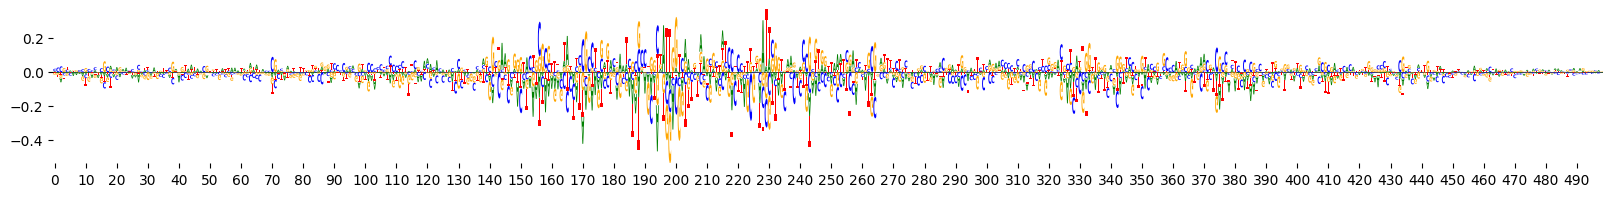

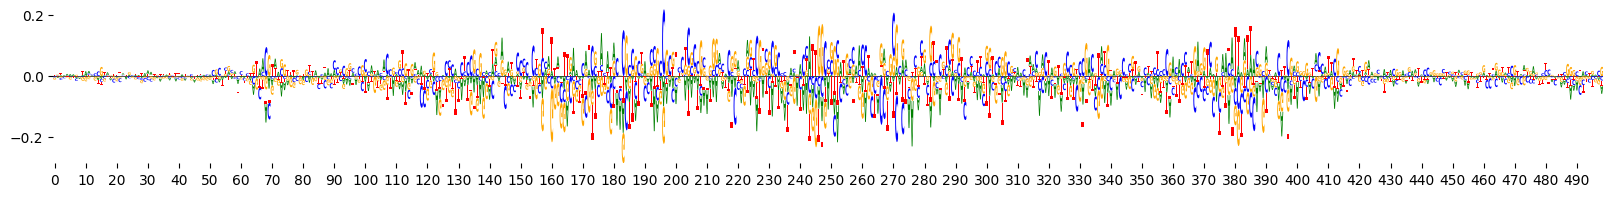

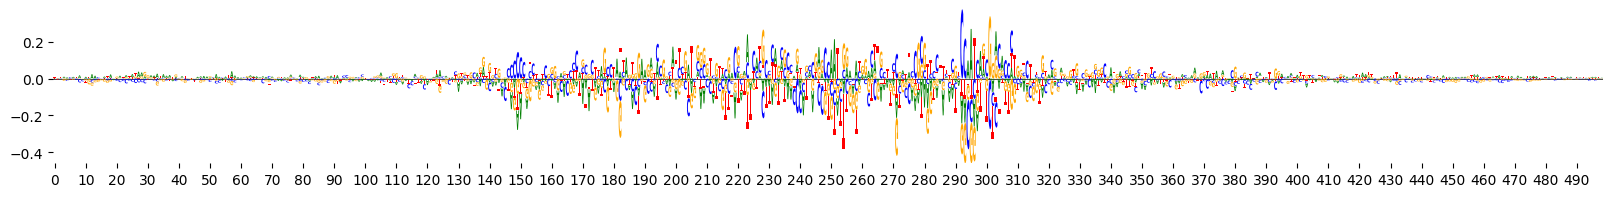

In [50]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        captum_attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

In [51]:
captum_attrs.shape

(3, 4, 500)

### Systematically extract motifs from the computed sequence attributions

In [149]:
test_actual = np.array(list(ad_test.X.toarray())).T
test_pred = np.array(preds_list).T
test_mask_motifs = np.sum((np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.), axis = 1) > 1
print(f'Selected {int(np.sum(test_mask_motifs))} sequences that differ at most 1 in cell types where they have signal over 5')

Selected 37 sequences that differ at most 1 in cell types where they have signal over 5


In [150]:
((np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.)).shape

(13390, 15)

In [151]:
print((np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.))

[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

In [152]:
np.sum((np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.), axis = 1).shape

(13390,)

In [153]:
print(np.sum((np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.), axis = 1))

[ 0  0  0  0  0  0  0  0 15  0  0  0 15  0  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  0  0  7  0  0  0  4  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 13  0  8  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [154]:
test_mask_motifs.shape

(13390,)

In [155]:
np.set_printoptions(threshold=np.inf)
print(test_mask_motifs)

[False False False False False False False False  True False False False
  True False False False False False False  True False False False False
 False False False False False False False False False  True False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [156]:
selected_indices = ad_test.var[test_mask_motifs]
selected_indices

chrom     start       end
49455  chr4     20623     21123
49459  chr4     28154     28654
49466  chr4     38650     39150
49480  chr4     54691     55191
49484  chr4     62269     62769
49520  chr4    119542    120042
49549  chr4    158096    158596
49577  chr4    211708    212208
49579  chr4    214350    214850
50351  chr4   2059026   2059526
50455  chr4   2321349   2321849
50816  chr4   3153480   3153980
51334  chr4   4752017   4752517
51620  chr4   5507005   5507505
51872  chr4   6142552   6143052
52075  chr4   6833227   6833727
52178  chr4   7222174   7222674
52659  chr4   8549371   8549871
52696  chr4   8614635   8615135
52937  chr4   9196082   9196582
53150  chr4   9836127   9836627
53175  chr4   9911276   9911776
53386  chr4  10603896  10604396
53805  chr4  11795170  11795670
53899  chr4  12046641  12047141
54169  chr4  12903303  12903803
55357  chr4  16312664  16313164
55733  chr4  17163413  17163913
56229  chr4  18666117  18666617
56782  chr4  20457928  20458428
56834  chr4  20622598  20623098
58344  chr4  25606839  25607339
59233  chr4  29164302  29164802
61678  chr4  72723283  72723783
61715  chr4  72959446  72959946
62189  chr4  74929056  74929556
62759  chr4  77933324  77933824

In [157]:
selected_indices.shape

(37, 3)

In [158]:
selected_seqs = grelu.sequence.format.convert_input_type(
    selected_indices,
    output_type="strings",
    genome=genome
)

selected_seqs

['ACCGGGCAGCGGGCACGAGCACTCGCCGGTAATCCCTCGCCGATCAAACGCTTTGATTTCTCCTCAGAATCGACTTTTCACAGTGTAATAAAGCGCGCGCCCCTCCCTGCGGCTGCCACACACACACACTCGCACACTGCCGGACCGCCCGAGCCCCGCTGCCGACGCCCCGCCCCTCACCGCTCCCCTCACTCTGATTGGACAGCGGCCGGGACCTCCGCGACGGTGATTGGAGGAGCAGTCGCTTCACTCAAACGCATCCTCGGATTTCTGGTTCCTGACTGTCGGGACCGGCTGTCAATCAGAGGTTCCCCCTGAGCTTCTCTGCGATTGGCCGAGCCCGCTCCCGCCCTCTGCCTGAGCCAGGTTAGCCCCGCCTCTTCCGCGCTGACATCCGGGCTCTTTCAGCGCGTCACCGTCAGCGCATTGTCTCCGCGTTTGCGTGTAAATCCGTAACCCTGACGAGCAGCGAGAGAGCTGATCAACCGATCACCAGCAGC',
 'GCTGTGCCGCCCGCAGCTGTCAATCAAAGTGCGGTTCTGTTTCCGGGTTGTCTCGGATGTTTGGCATATCGGTGTCTATGGAAACACGGGTCAGACGGACGCGGGCTCAGACCTCCGTGTGTTTTGTCTCCGTTGATTTCGGCTGGGAAATCGTTAAAAACACCGGCAGGTCCGATAGACCGTGAGGCGTCATAGCAGCGGTGTGTCCGCTAGAGGGAGACTCTTTCTCTCTCTCACACACACACACACACACACACACACACACACGCACACACATTAGACTCTTCTGCGCATGATCAGCTCTGCTCCGGTCGCTCATCTTCATGCTGCCGTTAACGGCGCTCGGTAGGACTCCTCACCGCTCGTGAGCTGCTCTTCTTCTGCTGCTCGTTGTGTGTGAACGCCGCTGTTCGAGGATTATTCGCCGGTAACGCGGATCTAAAGCGGAGAAACGGGCAAAGGAATAACGACACCGACAGCACGGGCGATCGGC

In [ ]:
cell_types = list(ad_test.obs_names)
cell_types

['anterior/posterior axis',
 'central nervous system',
 'forebrain',
 'immature eye',
 'integument',
 'lateral plate mesoderm',
 'mesenchyme cell',
 'musculature system',
 'neural crest',
 'neural keel',
 'neural stem cell',
 'periderm/epidermis',
 'primary neuron',
 'segmental plate',
 'YSL']

In [ ]:
ig_attrs_list = []

for cell_type in cell_types:
    prediction_transform = Aggregate(
        tasks = [cell_type],
        model = model,
    )

    ig_attrs = get_captum_integrated_gradients(model, selected_seqs, genome, prediction_transform, device=0, multiply_by_inputs= False)
    ig_attrs_list.append(ig_attrs)

In [223]:
len(ig_attrs_list)

15

In [178]:
# Transform list of length 15 with each element of shape (# selected_seqs, 4, 500) into a numpy array of shape (# selected_seqs, 15, 4, 500):

# Step 1: Stack into a single array of shape (15, 37, 4, 500)
stacked = np.stack(ig_attrs_list, axis=0)

# Step 2: Transpose to shape (37, 15, 4, 500)
gradattr = np.transpose(stacked, (1, 0, 2, 3))

gradattr.shape

(37, 15, 4, 500)

In [182]:
sigcut = 1.95 * np.mean(np.std(gradattr, axis = (-1,-2)))
print(f'Estimated cutoff for significance from standard deviation {sigcut}')

Estimated cutoff for significance from standard deviation 0.07403481117490046


In [219]:
selected_seqs_one_hot = grelu.sequence.format.strings_to_one_hot(selected_seqs)
selected_seqs_one_hot = selected_seqs_one_hot.numpy()
selected_seqs_one_hot.shape

(37, 4, 500)

In [222]:
selected_seqs_one_hot

array([[[1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

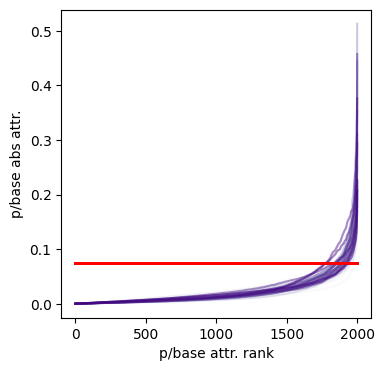

(37, 15, 4, 500) (37, 4, 500)
(37, 15, 500)


In [221]:
from motif_analysis import find_motifs
%matplotlib inline
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt

# Plot distribution of absolute attribution effect against their rank
# To determine best estimate for significance cut off 
nd = 37
rt = 8
colors = pl.cm.Purples(np.linspace(0,1,nd))
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
for i in range(nd):
    absgrad = np.abs(gradattr[i,rt].flatten())
    absgrad = np.sort(absgrad)
    rank = np.argsort(np.argsort(absgrad))
    ax.plot(rank, absgrad, alpha = 0.5, c = colors[i])
    ax.plot(rank, np.ones(len(rank))*sigcut, c = 'r')
ax.set_xlabel('p/base attr. rank')
ax.set_ylabel('p/base abs attr.')
plt.show()

# Use this cutoff to extract motifs from attributions for all tracks
# also record the mean and max effect, and scale attributions to abs max of 1 to cluster smaller motifs with larger ones
maxgap = 1 # Define max allowed gap
minsig = 4 # Define minumum number of significant bases
# Motifs are detected on the attributions of the reference base
print(gradattr.shape, selected_seqs_one_hot.shape)
stats = np.sum(gradattr * selected_seqs_one_hot[:, None], axis = -2)
print(stats.shape)
# From experience, we have seen that sometimes xAI methods can smear the attributions
# We don't want to include long motifs with no significance, so we also restrict ourselves 
# to motifs shorter than 30bp

In [225]:
selected_names = selected_indices.index
selected_names

Index(['49455', '49459', '49466', '49480', '49484', '49520', '49549', '49577',
       '49579', '50351', '50455', '50816', '51334', '51620', '51872', '52075',
       '52178', '52659', '52696', '52937', '53150', '53175', '53386', '53805',
       '53899', '54169', '55357', '55733', '56229', '56782', '56834', '58344',
       '59233', '61678', '61715', '62189', '62759'],
      dtype='object')

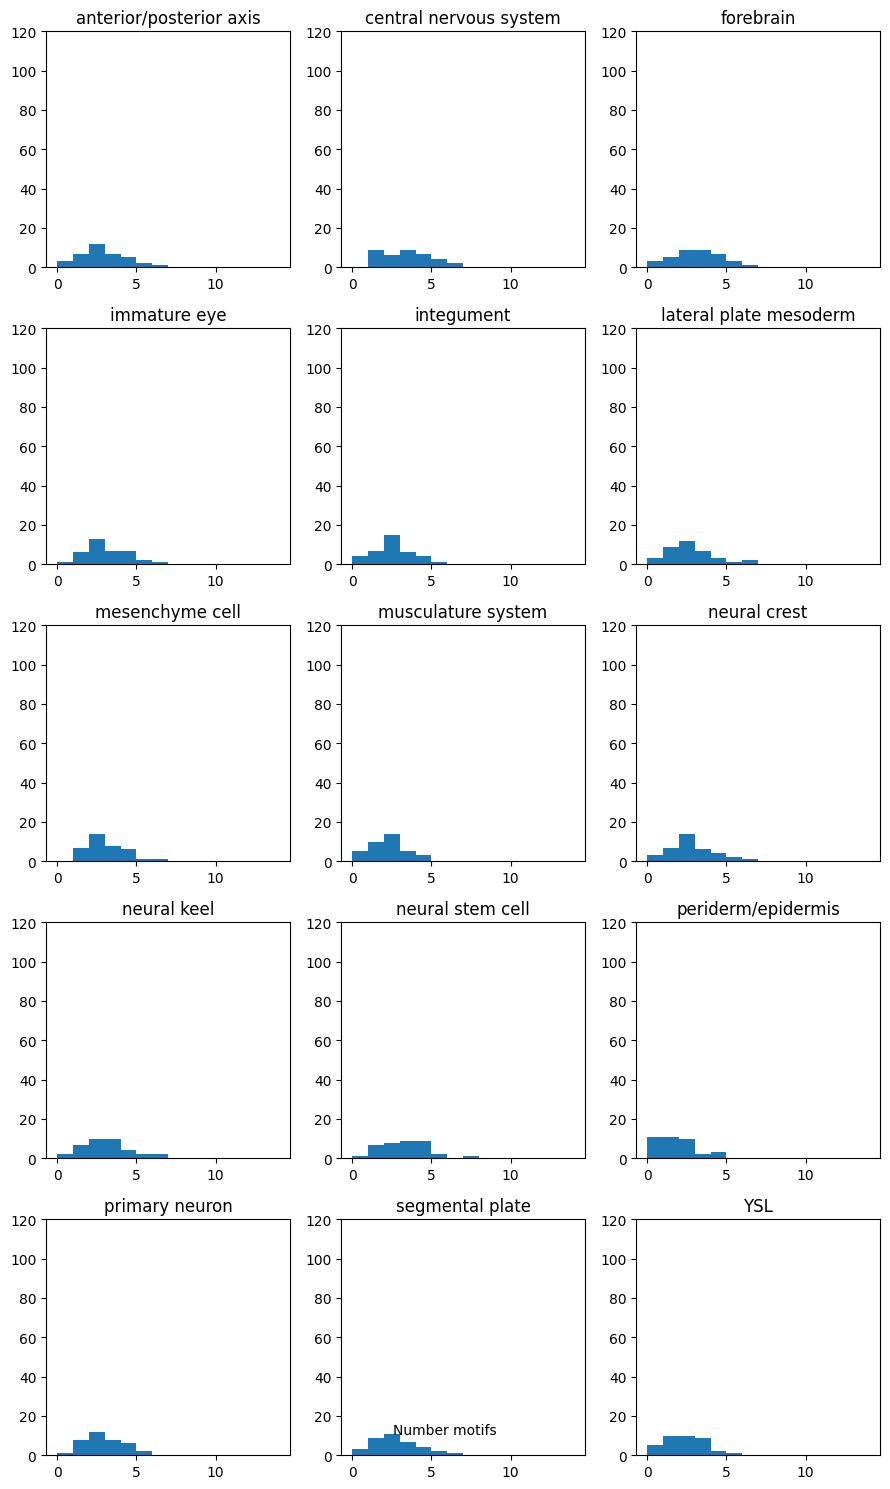

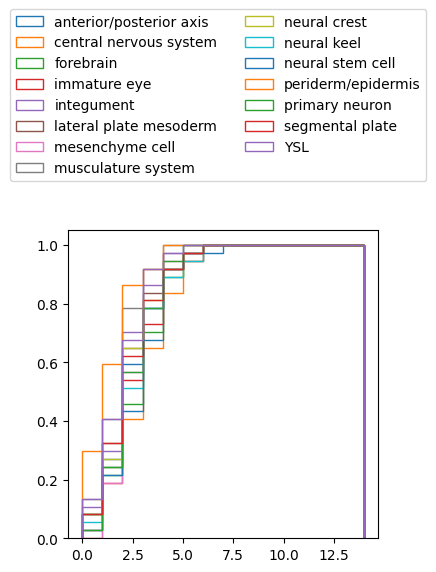

In [228]:
max_motlen = 30
normed_motifs = []
motif_mean_effect = []
motif_max_effect = []
motif_borders = []
motif_names = []
N_motifs = []
for c, ct in enumerate(cell_types):
    norm_mot, mot_mean, mot_max, mot_bor, n_mot, mot_name = [], [], [], [], [], []
    for i in range(gradattr.shape[0]):
        motiflocs = find_motifs(stats[i, c], sigcut, maxgap, minsig) # Returns a list of lists with positions of the motifs
        n_mot.append(len(motiflocs))
        for ml in motiflocs: 
            if ml[-1]-ml[0] < max_motlen:
                mot_bor.append([ml[0], ml[-1]+1])
                # Negative or positive max
                mot_max.append(stats[i, c][ml[0]: ml[-1]+1][np.argmax(np.abs(stats[i, c][ml[0]: ml[-1]+1]))])
                mot_mean.append(np.mean(stats[i, c][ml[0]: ml[-1]+1]))
                norm_mot.append(gradattr[i, c][:, ml[0]: ml[-1]+1]/mot_max[-1]) # To max normalized and sign adjusted motif
                mot_name.append(f'{selected_names[i]}_{ct}_{ml[0]}-{ml[-1]+1}')
            
    normed_motifs.append(norm_mot)
    motif_mean_effect.append(np.array(mot_mean))
    motif_max_effect.append(np.array(mot_max))
    motif_borders.append(np.array(mot_bor,dtype = int))
    N_motifs.append(n_mot)
    motif_names.append(np.array(mot_name, dtype = str))

output_path = os.path.expanduser('../results/')
model_stem = 'multi_task_DilatedConvModel.2025_27_04_19_18.version_0.checkpoints.epoch=7-step=37920.ckpt'
# Save the seqlets
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
np.savez_compressed(seqlet_file, names = np.array(motif_names, dtype = object), seqnames = selected_names, 
                    cells = cell_types, seqlets = np.array(normed_motifs, dtype = object), 
                    mean_effect = np.array(motif_mean_effect, dtype = object), max_effect = np.array(motif_max_effect, dtype = object), 
                    borders = np.array(motif_borders, dtype = object))

# For every cell type, plot the distribution of the number of motifs
fig, axes = plt.subplots(5, 3, figsize = (3 *3, 5*3))
for h, head in enumerate(cell_types):
    ax = axes[h//3,h%3]
    ax.hist(N_motifs[h], bins = np.arange(15))
    ax.set_title(head)
    ax.set_ylim([0,120])
plt.tight_layout()
fig.text(0.5, 0.04, 'Number motifs', ha='center')

figagg = plt.figure(figsize = (4,4))
axagg = plt.subplot(111)
for h, head in enumerate(cell_types):
    axagg.hist(N_motifs[h], bins = np.arange(15), cumulative=True, histtype = 'step', density = True, label = head)
figagg.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2)

plt.show()

### Cluster motifs and combine

Distance matrix of size (1286, 1286) computed in 2.1256065368652344
Clustering with matrix of size (1286, 1286) computed in 0.014386892318725586


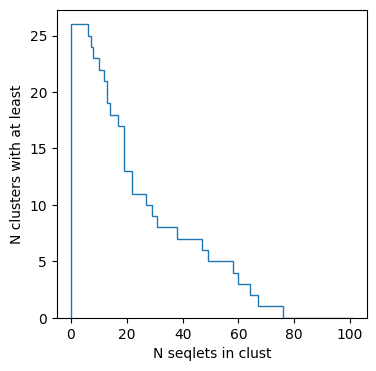

30
Saved PWM File as : ../results/multi_task_DilatedConvModel.2025_27_04_19_18.version_0.checkpoints.epoch=7-step=37920.ckpt_seqlets_cluster_cwms.meme


In [232]:
from motif_analysis import combine_pwms, torch_compute_similarity_motifs, assign_leftout_to_cluster
import numpy as np
from io_utils import write_meme_file
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time

# Load saved seqlets
output_path = os.path.expanduser('../results/')
model_stem = 'multi_task_DilatedConvModel.2025_27_04_19_18.version_0.checkpoints.epoch=7-step=37920.ckpt'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Make it a list and provide the seqlets in shape (l,4) to the algorithm
normed_motifs = [nm.T for nmm in normed_motifs for nm in nmm]
# Compute distance matrix between all seqlets from all cell types
# if return_alignment = True, then it returns the best offsets, and a binary matrix if the forward or reverse motif was aligned
# As distance metric, we are using the pvalue of the correlation coefficient
t0 = time.time()
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(normed_motifs, normed_motifs, 
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False, 
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0', 
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True, 
                                    sparse = False)
print(f'Distance matrix of size {motif_distance.shape} computed in {time.time()-t0}')
# With a distance matrix, one can use an clustering algorithm that to determine groups
# Agglomerative clustering has the advantage that it is highly interpretable and that we can use a distance threshold
# instead of defining a fixed number of clusters
# We use complete linkage and a threshold of 0.05, i.e. every motif in the cluster has a p-value < 0.05 to all other motifs
# in the same group
t0 = time.time()
clustering = AgglomerativeClustering(n_clusters = None, metric = 'precomputed', linkage = 'complete', 
                                     distance_threshold = 0.05)
clustering.fit(motif_distance)
print(f'Clustering with matrix of size {motif_distance.shape} computed in {time.time()-t0}')
clusters = clustering.labels_

# We save the cluster assignments to a file
np.savetxt(os.path.splitext(seqlet_file)[0]+'_cluster.txt', np.array([np.concatenate(motif_names, axis = 0), clusters], dtype = str).T, fmt = '%s')
# Let check how many seqlets are in each cluster
cluster_ids, n_seqlets = np.unique(clusters, return_counts=True)
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
n_seqlets[n_seqlets > 101] == 101
ax.hist(n_seqlets, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.set_xlabel('N seqlets in clust')
ax.set_ylabel('N clusters with at least')
plt.show()


# TODO: Alternatively select a random subset of 10%, compute distance matrix for it, cluster and later assign held out motifs to cluster
# This saves resources but requires more time

# Combine sequences to CWM and save as meme file
cluster_cwms = combine_pwms(normed_motifs, clusters, 1.-motif_distance, offsets, revcomp_matrix)
write_meme_file(cluster_cwms, cluster_ids.astype(str), 'ACGT', os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme', round = 2)


## Normalize motifs, find TFs with TomTom, assign names

The regulatory motifs for Zebra fish (Danio Rerio) were obtained from the [`SwissRegulon Portal`](https://swissregulon.unibas.ch/data/dr11/dr11_weight_matrices) as produced by the publication:

Baranasic, D., Hörtenhuber, M., Balwierz, P.J. et al. Multiomic atlas with functional stratification and developmental dynamics of zebrafish cis-regulatory elements. Nat Genet 54, 1037–1050 (2022). https://doi.org/10.1038/s41588-022-01089-w

Furthermore, the regulatory motifs (weight matrices) was converted from its original TRANSFAC 'matrix.dat' file into a MEME motif file by using the `transfac2meme` motif conversion utility from the [`The MEME Suite`](https://web.mit.edu/meme_v4.11.4/share/doc/transfac2meme.html).

In [ ]:
# Load the motifs from the meme file
from io_utils import read_meme
import os
import numpy as np

output_path = os.path.expanduser('../results/')
model_stem = 'multi_task_DilatedConvModel.2025_27_04_19_18.version_0.checkpoints.epoch=7-step=37920.ckpt'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
cwm_meme = os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
# Download motif databases here https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz
# Load pwms of motif database 
#database=os.path.expanduser('~/data/motif_databases/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2TF.meme')
database=os.path.expanduser('../data/danRer11.meme') # Path to a MEME file containing reference motifs for TOMTOM
TF_pfms, TFnames, nts = read_meme(database, nameline = 'MOTIF')

# Compute similarity matrix between cwms and pwms with drg and regturn correlation_pvalue
# Transform pfms to pwms
TF_pwms = []
for tfpf in TF_pfms:
    TF_pwms.append(np.log2((tfpf+0.25)/0.25))

from motif_analysis import torch_compute_similarity_motifs
# Potentially modify the cwms with exp, normalize to sum to 1, and create pwm to be more comparable. 
cluster_pwms = []
for clcw in cluster_cwms:
    clcw = np.exp(clcw) # Attributions are for log-scale values
    clcwsum = np.sum(clcw, 1)
    mask = np.where(clcwsum/np.amax(clcwsum) > 0.1)[0]
    clcw = clcw[mask[0]:mask[-1]+1]/clcwsum[:,None]
    cluster_pwms.append(np.log2((clcw+0.25)/0.25))

# Return p-values for correlation
correlation_pvalue = torch_compute_similarity_motifs(cluster_pwms, TF_pwms, metric = 'correlation_pvalue', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False )
print(correlation_pvalue[np.isinf(correlation_pvalue)], correlation_pvalue.shape)

# The algorithm sets negative correlations to be larger than 1
correlation_pvalue[correlation_pvalue>1] = 1
# correct for multiple testing along the axis of the motif database, with bejamini hochberg method
from scipy.stats import false_discovery_control 
correlation_qvalue = false_discovery_control(correlation_pvalue, axis=1, method='bh')

# write tomtom.tsv file for all matches with q < 0.05, and assign TF names to cluster name
cluster_name = []
tomtom = os.path.splitext(seqlet_file)[0]+'cluster_cwms.tomtom.tsv'
obj = open(tomtom, 'w')
obj.write('Query_ID\tTarget_ID\tOptimal_offset\tp-value\tCorrelation\tq-value\tOrientation\n')
for c, cid in enumerate(cluster_ids):
    cname = cid
    if (correlation_qvalue[c] < 0.05).any():
        cname += '('
        sort = np.argsort(correlation_qvalue[c])
        q, p, tid = correlation_qvalue[c][sort], correlation_pvalue[c][sort], TFnames[sort]
        cn = 0 
        for s in range(len(sort)):
            if q[s] < 0.05:
                obj.write(cid+'\t'+tid[s]+'\t.\t'+str(p[s])+'\t'+str(p[s])+'\t'+str(q[s])+'\t.\n')
                if cn < 5:
                    cname += tid[s]+';'
                    cn += 1
        cname = cname.strip(';')+')'
        print(cname, np.sum(q<0.05))
    cluster_name.append(cname)

cluster_name = np.array(cluster_name)

# Alternatively, one can compare the motifs to the motif database with tomtom from tangermeme
# or with the meme suite browser https://meme-suite.org/meme/tools/tomtom
# TODO, use tangermeme tomtom


[] (30, 590)
1(gata3) 1
2(tfdp1a+tfdp1b;egr1;egr2a+egr2b;klf5l+klf6a+klf6b;zbtb7a+zbtb7c) 5
3(atf1;gmeb2;e4f1+si:dkeyp-79b7.12;atf2;junba+junbb) 32
5(znf740a+znf740b;klf5l+klf6a+klf6b;zic3;prdm2a;rcor1) 8
6(zbtb14;klf7a+klf7b;tfdp1a+tfdp1b;egr1;gmeb1) 25
7(twist1a+twist1b+twist3;zic4+zic6;klf12b;runx2a+runx2b;ctcf) 21
9(gata5;gata4) 2
11(klf5l+klf6a+klf6b;znf740a+znf740b;zic3;mta3;rcor1) 6
12(nfic;sox6;sox9a+sox9b;onecut1+onecutl;sox5) 7
15(zbtb14;CABZ01079241.1+zfx+znf711;egr2a+egr2b) 3
16(pparab;rargb;esr1+esr2a+esr2b;rarga;nr4a2a) 34
18(nfia;nfic;nfixa+nfixb) 3
19(sox10) 1
23(sox10) 1
29(yy1a+yy1b;klf5l+klf6a+klf6b;tbx5a+tbx5b;tbx1;rcor1) 13


## Plot motifs in tree with detected number of occurrences, and mean, and max effect

In [ ]:
import plotlib as drgplt

# Of the hundreds of clusters, let's restrict the plot to clusters in neural.crest and large clusters of n > 10
# Load saved seqlets
output_path = os.path.expanduser('../results/')
model_stem = 'multi_task_DilatedConvModel.2025_27_04_19_18.version_0.checkpoints.epoch=7-step=37920.ckpt'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

motif_names = np.concatenate(motif_names, axis = 0)
motif_max_effect = np.concatenate(motif_max_effect, axis = 0)

# Load cluster motifs and ids
cwm_meme = os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
cluster_ids = cluster_ids.astype(int)

# We load the cluster assignments from file
cluster_file = np.genfromtxt(os.path.splitext(seqlet_file)[0]+'_cluster.txt', dtype = str)
motif_names, clusters = cluster_file[:,0], cluster_file[:,1].astype(int)


motif_mask = np.array(['neural.crest' in mf for mf in motif_names])
cluster_ids_nc, n_seqlets_nc = np.unique(clusters[motif_mask], return_counts=True)
n_seqlets = np.zeros(len(cluster_ids))

# This only works if clusters and cluster_ids are integer, otherwise cluster_ids_nc will not be sorted as integer but as string
n_seqlets[np.isin(cluster_ids, cluster_ids_nc)] = n_seqlets_nc
cluster_mask = n_seqlets > 10
print(f'{np.sum(cluster_mask)} clusters have more than 10 seqlets')

selected_cluster_cwms = [cw for c, cw in enumerate(cluster_cwms) if cluster_mask[c]]
# Compute the correlation distance matrix between the selected cluster motifs
cwm_correlation = torch_compute_similarity_motifs(selected_cluster_cwms, selected_cluster_cwms, metric = 'correlation', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False)

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = n_seqlets[cluster_mask].reshape(-1,1), # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {'barplot':True} # kwargs fro plot_distribution
                 )


# Collect the max-effects of the different motif clusters for a specific cell types from motif_mean_effect
cluster_effect_sizes = []
for ci in cluster_ids[cluster_mask]:
    cluster_effect_sizes.append(motif_max_effect[(clusters == ci)*(motif_mask)])

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = cluster_effect_sizes, # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
                 )
     

ValueError: Some errors were detected !
    Line #89 (got 4 columns instead of 3)
    Line #90 (got 4 columns instead of 3)
    Line #91 (got 4 columns instead of 3)
    Line #92 (got 4 columns instead of 3)
    Line #93 (got 4 columns instead of 3)
    Line #94 (got 4 columns instead of 3)
    Line #95 (got 4 columns instead of 3)
    Line #96 (got 4 columns instead of 3)
    Line #97 (got 4 columns instead of 3)
    Line #98 (got 4 columns instead of 3)
    Line #99 (got 4 columns instead of 3)
    Line #100 (got 4 columns instead of 3)
    Line #101 (got 4 columns instead of 3)
    Line #102 (got 4 columns instead of 3)
    Line #103 (got 4 columns instead of 3)
    Line #104 (got 4 columns instead of 3)
    Line #105 (got 4 columns instead of 3)
    Line #106 (got 4 columns instead of 3)
    Line #107 (got 4 columns instead of 3)
    Line #108 (got 4 columns instead of 3)
    Line #109 (got 4 columns instead of 3)
    Line #110 (got 4 columns instead of 3)
    Line #111 (got 4 columns instead of 3)
    Line #112 (got 4 columns instead of 3)
    Line #113 (got 4 columns instead of 3)
    Line #114 (got 4 columns instead of 3)
    Line #115 (got 4 columns instead of 3)
    Line #116 (got 4 columns instead of 3)
    Line #117 (got 4 columns instead of 3)
    Line #118 (got 4 columns instead of 3)
    Line #119 (got 4 columns instead of 3)
    Line #120 (got 4 columns instead of 3)
    Line #121 (got 4 columns instead of 3)
    Line #122 (got 4 columns instead of 3)
    Line #123 (got 4 columns instead of 3)
    Line #124 (got 4 columns instead of 3)
    Line #125 (got 4 columns instead of 3)
    Line #126 (got 4 columns instead of 3)
    Line #127 (got 4 columns instead of 3)
    Line #128 (got 4 columns instead of 3)
    Line #129 (got 4 columns instead of 3)
    Line #130 (got 4 columns instead of 3)
    Line #131 (got 4 columns instead of 3)
    Line #132 (got 4 columns instead of 3)
    Line #133 (got 4 columns instead of 3)
    Line #134 (got 4 columns instead of 3)
    Line #135 (got 4 columns instead of 3)
    Line #136 (got 4 columns instead of 3)
    Line #137 (got 4 columns instead of 3)
    Line #138 (got 4 columns instead of 3)
    Line #139 (got 4 columns instead of 3)
    Line #140 (got 4 columns instead of 3)
    Line #141 (got 4 columns instead of 3)
    Line #142 (got 4 columns instead of 3)
    Line #143 (got 4 columns instead of 3)
    Line #144 (got 4 columns instead of 3)
    Line #145 (got 4 columns instead of 3)
    Line #146 (got 4 columns instead of 3)
    Line #147 (got 4 columns instead of 3)
    Line #148 (got 4 columns instead of 3)
    Line #149 (got 4 columns instead of 3)
    Line #150 (got 4 columns instead of 3)
    Line #151 (got 4 columns instead of 3)
    Line #152 (got 4 columns instead of 3)
    Line #153 (got 4 columns instead of 3)
    Line #154 (got 4 columns instead of 3)
    Line #155 (got 4 columns instead of 3)
    Line #156 (got 4 columns instead of 3)
    Line #157 (got 4 columns instead of 3)
    Line #158 (got 4 columns instead of 3)
    Line #159 (got 4 columns instead of 3)
    Line #160 (got 4 columns instead of 3)
    Line #161 (got 4 columns instead of 3)
    Line #162 (got 4 columns instead of 3)
    Line #163 (got 4 columns instead of 3)
    Line #164 (got 4 columns instead of 3)
    Line #165 (got 4 columns instead of 3)
    Line #166 (got 4 columns instead of 3)
    Line #167 (got 4 columns instead of 3)
    Line #168 (got 4 columns instead of 3)
    Line #169 (got 4 columns instead of 3)
    Line #170 (got 4 columns instead of 3)
    Line #171 (got 4 columns instead of 3)
    Line #172 (got 4 columns instead of 3)
    Line #173 (got 4 columns instead of 3)
    Line #174 (got 4 columns instead of 3)
    Line #175 (got 4 columns instead of 3)
    Line #176 (got 4 columns instead of 3)
    Line #177 (got 4 columns instead of 3)
    Line #178 (got 4 columns instead of 3)
    Line #179 (got 4 columns instead of 3)
    Line #180 (got 4 columns instead of 3)
    Line #181 (got 4 columns instead of 3)
    Line #182 (got 4 columns instead of 3)
    Line #183 (got 4 columns instead of 3)
    Line #184 (got 4 columns instead of 3)
    Line #185 (got 4 columns instead of 3)
    Line #186 (got 4 columns instead of 3)
    Line #187 (got 4 columns instead of 3)
    Line #188 (got 4 columns instead of 3)
    Line #189 (got 4 columns instead of 3)
    Line #190 (got 4 columns instead of 3)
    Line #191 (got 4 columns instead of 3)
    Line #192 (got 4 columns instead of 3)
    Line #193 (got 4 columns instead of 3)
    Line #194 (got 4 columns instead of 3)
    Line #195 (got 4 columns instead of 3)
    Line #196 (got 4 columns instead of 3)
    Line #197 (got 2 columns instead of 3)
    Line #198 (got 2 columns instead of 3)
    Line #199 (got 2 columns instead of 3)
    Line #200 (got 2 columns instead of 3)
    Line #201 (got 2 columns instead of 3)
    Line #202 (got 2 columns instead of 3)
    Line #203 (got 2 columns instead of 3)
    Line #204 (got 2 columns instead of 3)
    Line #205 (got 2 columns instead of 3)
    Line #206 (got 2 columns instead of 3)
    Line #207 (got 2 columns instead of 3)
    Line #208 (got 2 columns instead of 3)
    Line #209 (got 2 columns instead of 3)
    Line #210 (got 2 columns instead of 3)
    Line #211 (got 2 columns instead of 3)
    Line #212 (got 2 columns instead of 3)
    Line #213 (got 2 columns instead of 3)
    Line #214 (got 2 columns instead of 3)
    Line #215 (got 2 columns instead of 3)
    Line #216 (got 2 columns instead of 3)
    Line #217 (got 2 columns instead of 3)
    Line #218 (got 2 columns instead of 3)
    Line #219 (got 2 columns instead of 3)
    Line #220 (got 2 columns instead of 3)
    Line #221 (got 2 columns instead of 3)
    Line #222 (got 2 columns instead of 3)
    Line #223 (got 2 columns instead of 3)
    Line #224 (got 2 columns instead of 3)
    Line #225 (got 2 columns instead of 3)
    Line #226 (got 2 columns instead of 3)
    Line #227 (got 2 columns instead of 3)
    Line #228 (got 2 columns instead of 3)
    Line #229 (got 2 columns instead of 3)
    Line #230 (got 2 columns instead of 3)
    Line #231 (got 2 columns instead of 3)
    Line #232 (got 2 columns instead of 3)
    Line #233 (got 2 columns instead of 3)
    Line #234 (got 2 columns instead of 3)
    Line #235 (got 2 columns instead of 3)
    Line #236 (got 2 columns instead of 3)
    Line #237 (got 2 columns instead of 3)
    Line #238 (got 2 columns instead of 3)
    Line #239 (got 2 columns instead of 3)
    Line #240 (got 2 columns instead of 3)
    Line #241 (got 2 columns instead of 3)
    Line #242 (got 2 columns instead of 3)
    Line #243 (got 2 columns instead of 3)
    Line #244 (got 2 columns instead of 3)
    Line #245 (got 2 columns instead of 3)
    Line #246 (got 2 columns instead of 3)
    Line #247 (got 2 columns instead of 3)
    Line #248 (got 2 columns instead of 3)
    Line #249 (got 2 columns instead of 3)
    Line #250 (got 2 columns instead of 3)
    Line #251 (got 2 columns instead of 3)
    Line #252 (got 2 columns instead of 3)
    Line #253 (got 2 columns instead of 3)
    Line #254 (got 2 columns instead of 3)
    Line #255 (got 2 columns instead of 3)
    Line #256 (got 2 columns instead of 3)
    Line #257 (got 2 columns instead of 3)
    Line #258 (got 2 columns instead of 3)
    Line #259 (got 2 columns instead of 3)
    Line #260 (got 2 columns instead of 3)
    Line #261 (got 2 columns instead of 3)
    Line #262 (got 2 columns instead of 3)
    Line #263 (got 2 columns instead of 3)
    Line #264 (got 2 columns instead of 3)
    Line #265 (got 2 columns instead of 3)
    Line #266 (got 2 columns instead of 3)
    Line #267 (got 2 columns instead of 3)
    Line #268 (got 2 columns instead of 3)
    Line #269 (got 2 columns instead of 3)
    Line #270 (got 2 columns instead of 3)
    Line #271 (got 2 columns instead of 3)
    Line #272 (got 2 columns instead of 3)
    Line #273 (got 2 columns instead of 3)
    Line #274 (got 2 columns instead of 3)
    Line #275 (got 2 columns instead of 3)
    Line #276 (got 2 columns instead of 3)
    Line #277 (got 2 columns instead of 3)
    Line #278 (got 2 columns instead of 3)
    Line #279 (got 2 columns instead of 3)
    Line #280 (got 2 columns instead of 3)
    Line #281 (got 2 columns instead of 3)
    Line #282 (got 2 columns instead of 3)
    Line #283 (got 2 columns instead of 3)
    Line #284 (got 2 columns instead of 3)
    Line #285 (got 2 columns instead of 3)
    Line #286 (got 2 columns instead of 3)
    Line #287 (got 2 columns instead of 3)
    Line #288 (got 2 columns instead of 3)
    Line #289 (got 2 columns instead of 3)
    Line #290 (got 2 columns instead of 3)
    Line #291 (got 2 columns instead of 3)
    Line #292 (got 2 columns instead of 3)
    Line #293 (got 2 columns instead of 3)
    Line #294 (got 2 columns instead of 3)
    Line #295 (got 2 columns instead of 3)
    Line #393 (got 2 columns instead of 3)
    Line #394 (got 2 columns instead of 3)
    Line #395 (got 2 columns instead of 3)
    Line #396 (got 2 columns instead of 3)
    Line #397 (got 2 columns instead of 3)
    Line #398 (got 2 columns instead of 3)
    Line #399 (got 2 columns instead of 3)
    Line #400 (got 2 columns instead of 3)
    Line #401 (got 2 columns instead of 3)
    Line #402 (got 2 columns instead of 3)
    Line #403 (got 2 columns instead of 3)
    Line #404 (got 2 columns instead of 3)
    Line #405 (got 2 columns instead of 3)
    Line #406 (got 2 columns instead of 3)
    Line #407 (got 2 columns instead of 3)
    Line #408 (got 2 columns instead of 3)
    Line #409 (got 2 columns instead of 3)
    Line #410 (got 2 columns instead of 3)
    Line #411 (got 2 columns instead of 3)
    Line #412 (got 2 columns instead of 3)
    Line #413 (got 2 columns instead of 3)
    Line #414 (got 2 columns instead of 3)
    Line #415 (got 2 columns instead of 3)
    Line #416 (got 2 columns instead of 3)
    Line #417 (got 2 columns instead of 3)
    Line #418 (got 2 columns instead of 3)
    Line #419 (got 2 columns instead of 3)
    Line #420 (got 2 columns instead of 3)
    Line #421 (got 2 columns instead of 3)
    Line #422 (got 2 columns instead of 3)
    Line #423 (got 2 columns instead of 3)
    Line #424 (got 2 columns instead of 3)
    Line #425 (got 2 columns instead of 3)
    Line #426 (got 2 columns instead of 3)
    Line #427 (got 2 columns instead of 3)
    Line #428 (got 2 columns instead of 3)
    Line #429 (got 2 columns instead of 3)
    Line #430 (got 2 columns instead of 3)
    Line #431 (got 2 columns instead of 3)
    Line #432 (got 2 columns instead of 3)
    Line #433 (got 2 columns instead of 3)
    Line #434 (got 2 columns instead of 3)
    Line #435 (got 2 columns instead of 3)
    Line #436 (got 2 columns instead of 3)
    Line #437 (got 2 columns instead of 3)
    Line #438 (got 2 columns instead of 3)
    Line #439 (got 2 columns instead of 3)
    Line #440 (got 2 columns instead of 3)
    Line #441 (got 2 columns instead of 3)
    Line #442 (got 2 columns instead of 3)
    Line #443 (got 2 columns instead of 3)
    Line #444 (got 2 columns instead of 3)
    Line #445 (got 2 columns instead of 3)
    Line #446 (got 2 columns instead of 3)
    Line #447 (got 2 columns instead of 3)
    Line #448 (got 2 columns instead of 3)
    Line #449 (got 2 columns instead of 3)
    Line #450 (got 2 columns instead of 3)
    Line #451 (got 2 columns instead of 3)
    Line #452 (got 2 columns instead of 3)
    Line #453 (got 2 columns instead of 3)
    Line #454 (got 2 columns instead of 3)
    Line #455 (got 2 columns instead of 3)
    Line #456 (got 2 columns instead of 3)
    Line #457 (got 2 columns instead of 3)
    Line #458 (got 2 columns instead of 3)
    Line #459 (got 2 columns instead of 3)
    Line #460 (got 2 columns instead of 3)
    Line #461 (got 2 columns instead of 3)
    Line #462 (got 2 columns instead of 3)
    Line #463 (got 2 columns instead of 3)
    Line #464 (got 2 columns instead of 3)
    Line #465 (got 2 columns instead of 3)
    Line #466 (got 2 columns instead of 3)
    Line #467 (got 2 columns instead of 3)
    Line #468 (got 2 columns instead of 3)
    Line #469 (got 4 columns instead of 3)
    Line #470 (got 4 columns instead of 3)
    Line #471 (got 4 columns instead of 3)
    Line #472 (got 4 columns instead of 3)
    Line #473 (got 4 columns instead of 3)
    Line #474 (got 4 columns instead of 3)
    Line #475 (got 4 columns instead of 3)
    Line #476 (got 4 columns instead of 3)
    Line #477 (got 4 columns instead of 3)
    Line #478 (got 4 columns instead of 3)
    Line #479 (got 4 columns instead of 3)
    Line #480 (got 4 columns instead of 3)
    Line #481 (got 4 columns instead of 3)
    Line #482 (got 4 columns instead of 3)
    Line #483 (got 4 columns instead of 3)
    Line #484 (got 4 columns instead of 3)
    Line #485 (got 4 columns instead of 3)
    Line #486 (got 4 columns instead of 3)
    Line #487 (got 4 columns instead of 3)
    Line #488 (got 4 columns instead of 3)
    Line #489 (got 4 columns instead of 3)
    Line #490 (got 4 columns instead of 3)
    Line #491 (got 4 columns instead of 3)
    Line #492 (got 4 columns instead of 3)
    Line #493 (got 4 columns instead of 3)
    Line #494 (got 4 columns instead of 3)
    Line #495 (got 4 columns instead of 3)
    Line #496 (got 4 columns instead of 3)
    Line #497 (got 4 columns instead of 3)
    Line #498 (got 4 columns instead of 3)
    Line #499 (got 4 columns instead of 3)
    Line #500 (got 4 columns instead of 3)
    Line #501 (got 4 columns instead of 3)
    Line #502 (got 4 columns instead of 3)
    Line #503 (got 4 columns instead of 3)
    Line #504 (got 4 columns instead of 3)
    Line #505 (got 4 columns instead of 3)
    Line #506 (got 4 columns instead of 3)
    Line #507 (got 4 columns instead of 3)
    Line #508 (got 4 columns instead of 3)
    Line #509 (got 4 columns instead of 3)
    Line #510 (got 4 columns instead of 3)
    Line #511 (got 4 columns instead of 3)
    Line #512 (got 4 columns instead of 3)
    Line #513 (got 4 columns instead of 3)
    Line #514 (got 4 columns instead of 3)
    Line #515 (got 4 columns instead of 3)
    Line #516 (got 4 columns instead of 3)
    Line #517 (got 4 columns instead of 3)
    Line #518 (got 4 columns instead of 3)
    Line #519 (got 4 columns instead of 3)
    Line #520 (got 4 columns instead of 3)
    Line #521 (got 4 columns instead of 3)
    Line #522 (got 4 columns instead of 3)
    Line #523 (got 4 columns instead of 3)
    Line #524 (got 4 columns instead of 3)
    Line #525 (got 4 columns instead of 3)
    Line #526 (got 4 columns instead of 3)
    Line #527 (got 4 columns instead of 3)
    Line #528 (got 4 columns instead of 3)
    Line #529 (got 4 columns instead of 3)
    Line #530 (got 4 columns instead of 3)
    Line #531 (got 4 columns instead of 3)
    Line #532 (got 4 columns instead of 3)
    Line #533 (got 4 columns instead of 3)
    Line #534 (got 4 columns instead of 3)
    Line #535 (got 4 columns instead of 3)
    Line #536 (got 4 columns instead of 3)
    Line #537 (got 4 columns instead of 3)
    Line #538 (got 4 columns instead of 3)
    Line #539 (got 4 columns instead of 3)
    Line #540 (got 4 columns instead of 3)
    Line #541 (got 4 columns instead of 3)
    Line #542 (got 4 columns instead of 3)
    Line #543 (got 4 columns instead of 3)
    Line #544 (got 4 columns instead of 3)
    Line #545 (got 4 columns instead of 3)
    Line #546 (got 4 columns instead of 3)
    Line #547 (got 4 columns instead of 3)
    Line #548 (got 4 columns instead of 3)
    Line #549 (got 4 columns instead of 3)
    Line #550 (got 4 columns instead of 3)
    Line #551 (got 4 columns instead of 3)
    Line #891 (got 4 columns instead of 3)
    Line #892 (got 4 columns instead of 3)
    Line #893 (got 4 columns instead of 3)
    Line #894 (got 4 columns instead of 3)
    Line #895 (got 4 columns instead of 3)
    Line #896 (got 4 columns instead of 3)
    Line #897 (got 4 columns instead of 3)
    Line #898 (got 4 columns instead of 3)
    Line #899 (got 4 columns instead of 3)
    Line #900 (got 4 columns instead of 3)
    Line #901 (got 4 columns instead of 3)
    Line #902 (got 4 columns instead of 3)
    Line #903 (got 4 columns instead of 3)
    Line #904 (got 4 columns instead of 3)
    Line #905 (got 4 columns instead of 3)
    Line #906 (got 4 columns instead of 3)
    Line #907 (got 4 columns instead of 3)
    Line #908 (got 4 columns instead of 3)
    Line #909 (got 4 columns instead of 3)
    Line #910 (got 4 columns instead of 3)
    Line #911 (got 4 columns instead of 3)
    Line #912 (got 4 columns instead of 3)
    Line #913 (got 4 columns instead of 3)
    Line #914 (got 4 columns instead of 3)
    Line #915 (got 4 columns instead of 3)
    Line #916 (got 4 columns instead of 3)
    Line #917 (got 4 columns instead of 3)
    Line #918 (got 4 columns instead of 3)
    Line #919 (got 4 columns instead of 3)
    Line #920 (got 4 columns instead of 3)
    Line #921 (got 4 columns instead of 3)
    Line #922 (got 4 columns instead of 3)
    Line #923 (got 4 columns instead of 3)
    Line #924 (got 4 columns instead of 3)
    Line #925 (got 4 columns instead of 3)
    Line #926 (got 4 columns instead of 3)
    Line #927 (got 4 columns instead of 3)
    Line #928 (got 4 columns instead of 3)
    Line #929 (got 4 columns instead of 3)
    Line #930 (got 4 columns instead of 3)
    Line #931 (got 4 columns instead of 3)
    Line #932 (got 4 columns instead of 3)
    Line #933 (got 4 columns instead of 3)
    Line #934 (got 4 columns instead of 3)
    Line #935 (got 4 columns instead of 3)
    Line #936 (got 4 columns instead of 3)
    Line #937 (got 4 columns instead of 3)
    Line #938 (got 4 columns instead of 3)
    Line #939 (got 4 columns instead of 3)
    Line #940 (got 4 columns instead of 3)
    Line #941 (got 4 columns instead of 3)
    Line #942 (got 4 columns instead of 3)
    Line #943 (got 4 columns instead of 3)
    Line #944 (got 4 columns instead of 3)
    Line #945 (got 4 columns instead of 3)
    Line #946 (got 4 columns instead of 3)
    Line #947 (got 4 columns instead of 3)
    Line #948 (got 4 columns instead of 3)
    Line #949 (got 4 columns instead of 3)
    Line #950 (got 4 columns instead of 3)
    Line #951 (got 4 columns instead of 3)
    Line #952 (got 4 columns instead of 3)
    Line #953 (got 4 columns instead of 3)
    Line #954 (got 4 columns instead of 3)
    Line #955 (got 4 columns instead of 3)
    Line #956 (got 4 columns instead of 3)
    Line #957 (got 4 columns instead of 3)
    Line #958 (got 4 columns instead of 3)
    Line #959 (got 4 columns instead of 3)
    Line #960 (got 4 columns instead of 3)
    Line #961 (got 4 columns instead of 3)
    Line #962 (got 4 columns instead of 3)
    Line #963 (got 4 columns instead of 3)
    Line #964 (got 4 columns instead of 3)
    Line #965 (got 4 columns instead of 3)
    Line #966 (got 4 columns instead of 3)
    Line #967 (got 4 columns instead of 3)
    Line #968 (got 4 columns instead of 3)
    Line #969 (got 4 columns instead of 3)
    Line #970 (got 4 columns instead of 3)
    Line #971 (got 4 columns instead of 3)
    Line #972 (got 4 columns instead of 3)
    Line #973 (got 4 columns instead of 3)
    Line #974 (got 4 columns instead of 3)
    Line #975 (got 4 columns instead of 3)
    Line #976 (got 4 columns instead of 3)
    Line #977 (got 4 columns instead of 3)
    Line #978 (got 4 columns instead of 3)
    Line #979 (got 4 columns instead of 3)
    Line #980 (got 4 columns instead of 3)
    Line #981 (got 4 columns instead of 3)
    Line #982 (got 4 columns instead of 3)
    Line #983 (got 4 columns instead of 3)
    Line #984 (got 4 columns instead of 3)
    Line #985 (got 4 columns instead of 3)
    Line #986 (got 4 columns instead of 3)
    Line #987 (got 4 columns instead of 3)
    Line #988 (got 4 columns instead of 3)
    Line #989 (got 4 columns instead of 3)
    Line #990 (got 4 columns instead of 3)
    Line #991 (got 4 columns instead of 3)
    Line #992 (got 4 columns instead of 3)
    Line #993 (got 4 columns instead of 3)
    Line #994 (got 2 columns instead of 3)
    Line #995 (got 2 columns instead of 3)
    Line #996 (got 2 columns instead of 3)
    Line #997 (got 2 columns instead of 3)
    Line #998 (got 2 columns instead of 3)
    Line #999 (got 2 columns instead of 3)
    Line #1000 (got 2 columns instead of 3)
    Line #1001 (got 2 columns instead of 3)
    Line #1002 (got 2 columns instead of 3)
    Line #1003 (got 2 columns instead of 3)
    Line #1004 (got 2 columns instead of 3)
    Line #1005 (got 2 columns instead of 3)
    Line #1006 (got 2 columns instead of 3)
    Line #1007 (got 2 columns instead of 3)
    Line #1008 (got 2 columns instead of 3)
    Line #1009 (got 2 columns instead of 3)
    Line #1010 (got 2 columns instead of 3)
    Line #1011 (got 2 columns instead of 3)
    Line #1012 (got 2 columns instead of 3)
    Line #1013 (got 2 columns instead of 3)
    Line #1014 (got 2 columns instead of 3)
    Line #1015 (got 2 columns instead of 3)
    Line #1016 (got 2 columns instead of 3)
    Line #1017 (got 2 columns instead of 3)
    Line #1018 (got 2 columns instead of 3)
    Line #1019 (got 2 columns instead of 3)
    Line #1020 (got 2 columns instead of 3)
    Line #1021 (got 2 columns instead of 3)
    Line #1022 (got 2 columns instead of 3)
    Line #1023 (got 2 columns instead of 3)
    Line #1024 (got 2 columns instead of 3)
    Line #1025 (got 2 columns instead of 3)
    Line #1026 (got 2 columns instead of 3)
    Line #1027 (got 2 columns instead of 3)
    Line #1028 (got 2 columns instead of 3)
    Line #1029 (got 2 columns instead of 3)
    Line #1030 (got 2 columns instead of 3)
    Line #1031 (got 2 columns instead of 3)
    Line #1032 (got 2 columns instead of 3)
    Line #1033 (got 2 columns instead of 3)
    Line #1034 (got 2 columns instead of 3)
    Line #1035 (got 2 columns instead of 3)
    Line #1036 (got 2 columns instead of 3)
    Line #1037 (got 2 columns instead of 3)
    Line #1038 (got 2 columns instead of 3)
    Line #1039 (got 2 columns instead of 3)
    Line #1040 (got 2 columns instead of 3)
    Line #1041 (got 2 columns instead of 3)
    Line #1042 (got 2 columns instead of 3)
    Line #1217 (got 2 columns instead of 3)
    Line #1218 (got 2 columns instead of 3)
    Line #1219 (got 2 columns instead of 3)
    Line #1220 (got 2 columns instead of 3)
    Line #1221 (got 2 columns instead of 3)
    Line #1222 (got 2 columns instead of 3)
    Line #1223 (got 2 columns instead of 3)
    Line #1224 (got 2 columns instead of 3)
    Line #1225 (got 2 columns instead of 3)
    Line #1226 (got 2 columns instead of 3)
    Line #1227 (got 2 columns instead of 3)
    Line #1228 (got 2 columns instead of 3)
    Line #1229 (got 2 columns instead of 3)
    Line #1230 (got 2 columns instead of 3)
    Line #1231 (got 2 columns instead of 3)
    Line #1232 (got 2 columns instead of 3)
    Line #1233 (got 2 columns instead of 3)
    Line #1234 (got 2 columns instead of 3)
    Line #1235 (got 2 columns instead of 3)
    Line #1236 (got 2 columns instead of 3)
    Line #1237 (got 2 columns instead of 3)
    Line #1238 (got 2 columns instead of 3)
    Line #1239 (got 2 columns instead of 3)
    Line #1240 (got 2 columns instead of 3)
    Line #1241 (got 2 columns instead of 3)
    Line #1242 (got 2 columns instead of 3)
    Line #1243 (got 2 columns instead of 3)
    Line #1244 (got 2 columns instead of 3)
    Line #1245 (got 2 columns instead of 3)
    Line #1246 (got 2 columns instead of 3)
    Line #1247 (got 2 columns instead of 3)
    Line #1248 (got 2 columns instead of 3)
    Line #1249 (got 2 columns instead of 3)
    Line #1250 (got 2 columns instead of 3)
    Line #1251 (got 2 columns instead of 3)
    Line #1252 (got 2 columns instead of 3)
    Line #1253 (got 2 columns instead of 3)
    Line #1254 (got 2 columns instead of 3)
    Line #1255 (got 2 columns instead of 3)
    Line #1256 (got 2 columns instead of 3)
    Line #1257 (got 2 columns instead of 3)
    Line #1258 (got 2 columns instead of 3)
    Line #1259 (got 2 columns instead of 3)
    Line #1260 (got 2 columns instead of 3)
    Line #1261 (got 2 columns instead of 3)
    Line #1262 (got 2 columns instead of 3)
    Line #1263 (got 2 columns instead of 3)
    Line #1264 (got 2 columns instead of 3)
    Line #1265 (got 2 columns instead of 3)
    Line #1266 (got 2 columns instead of 3)
    Line #1267 (got 2 columns instead of 3)
    Line #1268 (got 2 columns instead of 3)
    Line #1269 (got 2 columns instead of 3)
    Line #1270 (got 2 columns instead of 3)
    Line #1271 (got 2 columns instead of 3)
    Line #1272 (got 2 columns instead of 3)
    Line #1273 (got 2 columns instead of 3)
    Line #1274 (got 2 columns instead of 3)
    Line #1275 (got 2 columns instead of 3)
    Line #1276 (got 2 columns instead of 3)
    Line #1277 (got 2 columns instead of 3)
    Line #1278 (got 2 columns instead of 3)
    Line #1279 (got 2 columns instead of 3)
    Line #1280 (got 2 columns instead of 3)
    Line #1281 (got 2 columns instead of 3)
    Line #1282 (got 2 columns instead of 3)
    Line #1283 (got 2 columns instead of 3)
    Line #1284 (got 2 columns instead of 3)
    Line #1285 (got 2 columns instead of 3)
    Line #1286 (got 2 columns instead of 3)

## To do

- Work on normalizing names to avoid spaces and /. Rather, replace spaces and / with .